# **Prevendo Doenças Cardiovasculares com Regressão Logística**


Nesse projeto será construido um modelo que ajuda a prever doenças cardiovasculares. O objetivo é utilizar dados históricos dos pacientes e construir um bom modelo de regressão capaz de indicar se novos pacientes estão propensos a doenças cariovasculares ou não, a base contém os seguintes dados:


age - idade dos pacientes

gender - genero (2 mulheres) (1 homens)

height - altura dos pacientes

weight - peso dos pacientes

gluc - glicose

smoke - fumante (1) não fumante (0)

alco - consume alcool (1) não consome (0)

active - realiza atividades fisicas (1) não realiza (0)

cardio_disease - tem doença cardio (1) não tem (0) - Variável target


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import sys
sys.path.append('../')

from src.EDA import boxplot, outliers_iqr, histograma, plot_categoricas, categoricasXtarget, correlacao

## **Carregando e tratando a base de dados**
Verifcando os tipos de dados, se há dados faltantes e outliers.

In [2]:
base = pd.read_csv("../base/CARDIO_BASE.csv", sep=";")

In [3]:
# renomeando colunas para portugues
base = base.rename(columns={
    "age": "idade",
    "height": "altura",
    "gender": "genero",
    "weight": "peso",
    "cholesterol": "colesterol",
    "cardio_disease": "doenca cardiaca", 
    "gluc": "glicose",
    "smoke": "fumante",
    "alco": "alcool",
    "active": "ativo"
})

base.head()

,idade,genero,altura,peso,colesterol,glicose,fumante,alcool,ativo,doenca cardiaca
0,50,2,168,62,1,1,0,0,1,0
1,55,1,156,85,3,1,0,0,1,1
2,52,1,165,64,3,1,0,0,0,1
3,48,2,169,82,1,1,0,0,1,1
4,48,1,156,56,1,1,0,0,0,0


In [4]:
# analisando os dados
print("\nEstatísticas descritivas das colunas numéricas:\n")
print(base[['idade', 'altura', 'peso', 'colesterol', 'glicose']].describe())
print("\n")

print("\nTipos de dados das colunas:")
print(base.dtypes)
print("\n")

print("Porcentagem de nulos")
print(f"{base.isnull().sum() * 100}")



Estatísticas descritivas das colunas numéricas:

              idade        altura    colesterol       glicose
count  10000.000000  10000.000000  10000.000000  10000.000000
mean      53.288300    164.308200      1.365000      1.222200
std        6.796234      8.178796      0.677658      0.565561
min       30.000000     70.000000      1.000000      1.000000
25%       48.000000    159.000000      1.000000      1.000000
50%       54.000000    165.000000      1.000000      1.000000
75%       58.000000    170.000000      2.000000      1.000000
max       65.000000    250.000000      3.000000      3.000000



Tipos de dados das colunas:
idade               int64
genero              int64
altura              int64
peso               object
colesterol          int64
glicose             int64
fumante             int64
alcool              int64
ativo               int64
doenca cardiaca     int64
dtype: object


Porcentagem de nulos
idade              0
genero             0
altura             0
p

In [5]:
# mudando pesol para float
base["peso"] = base["peso"].str.replace(",", ".").astype(float)

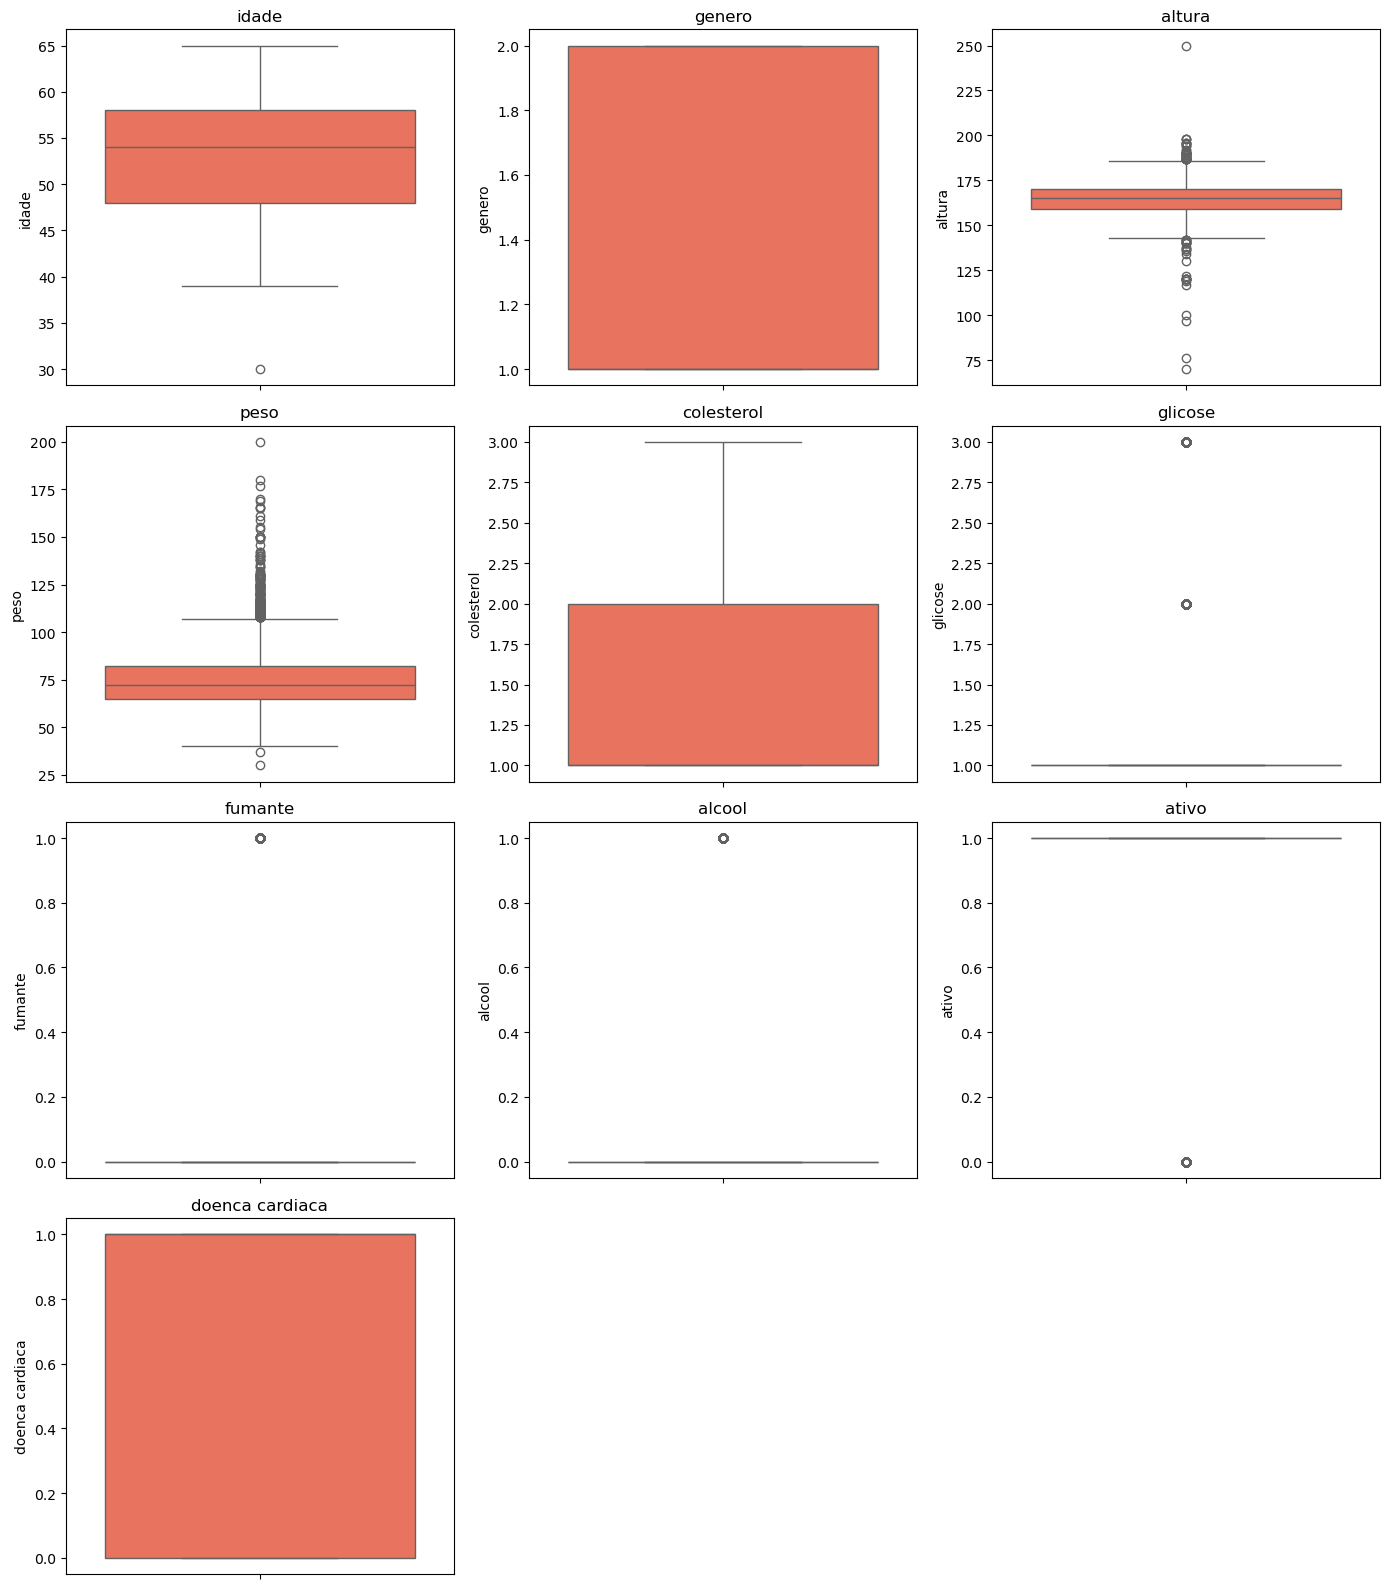

In [6]:
# verificando outiliers
boxplot(base)

Após a análise dos boxplots, foi possível identificar a presença de outliers, sendo alguns valores legítimos e outros apenas anomalias. Dessa forma, decidiu-se remover da base as pessoas com altura inferior a 1,40 m, superior a 2,30 m e aquelas com peso abaixo de 40 kg.
Mesmo apenas com a visualização por boxplot, já é possível extrair algumas observações sobre os dados, por exemplo, a maior parte das pessoas com doenças cardíacas é fisicamente ativa, não consome álcool e não fuma, algo que, a primeira vista, não seria o esperado.

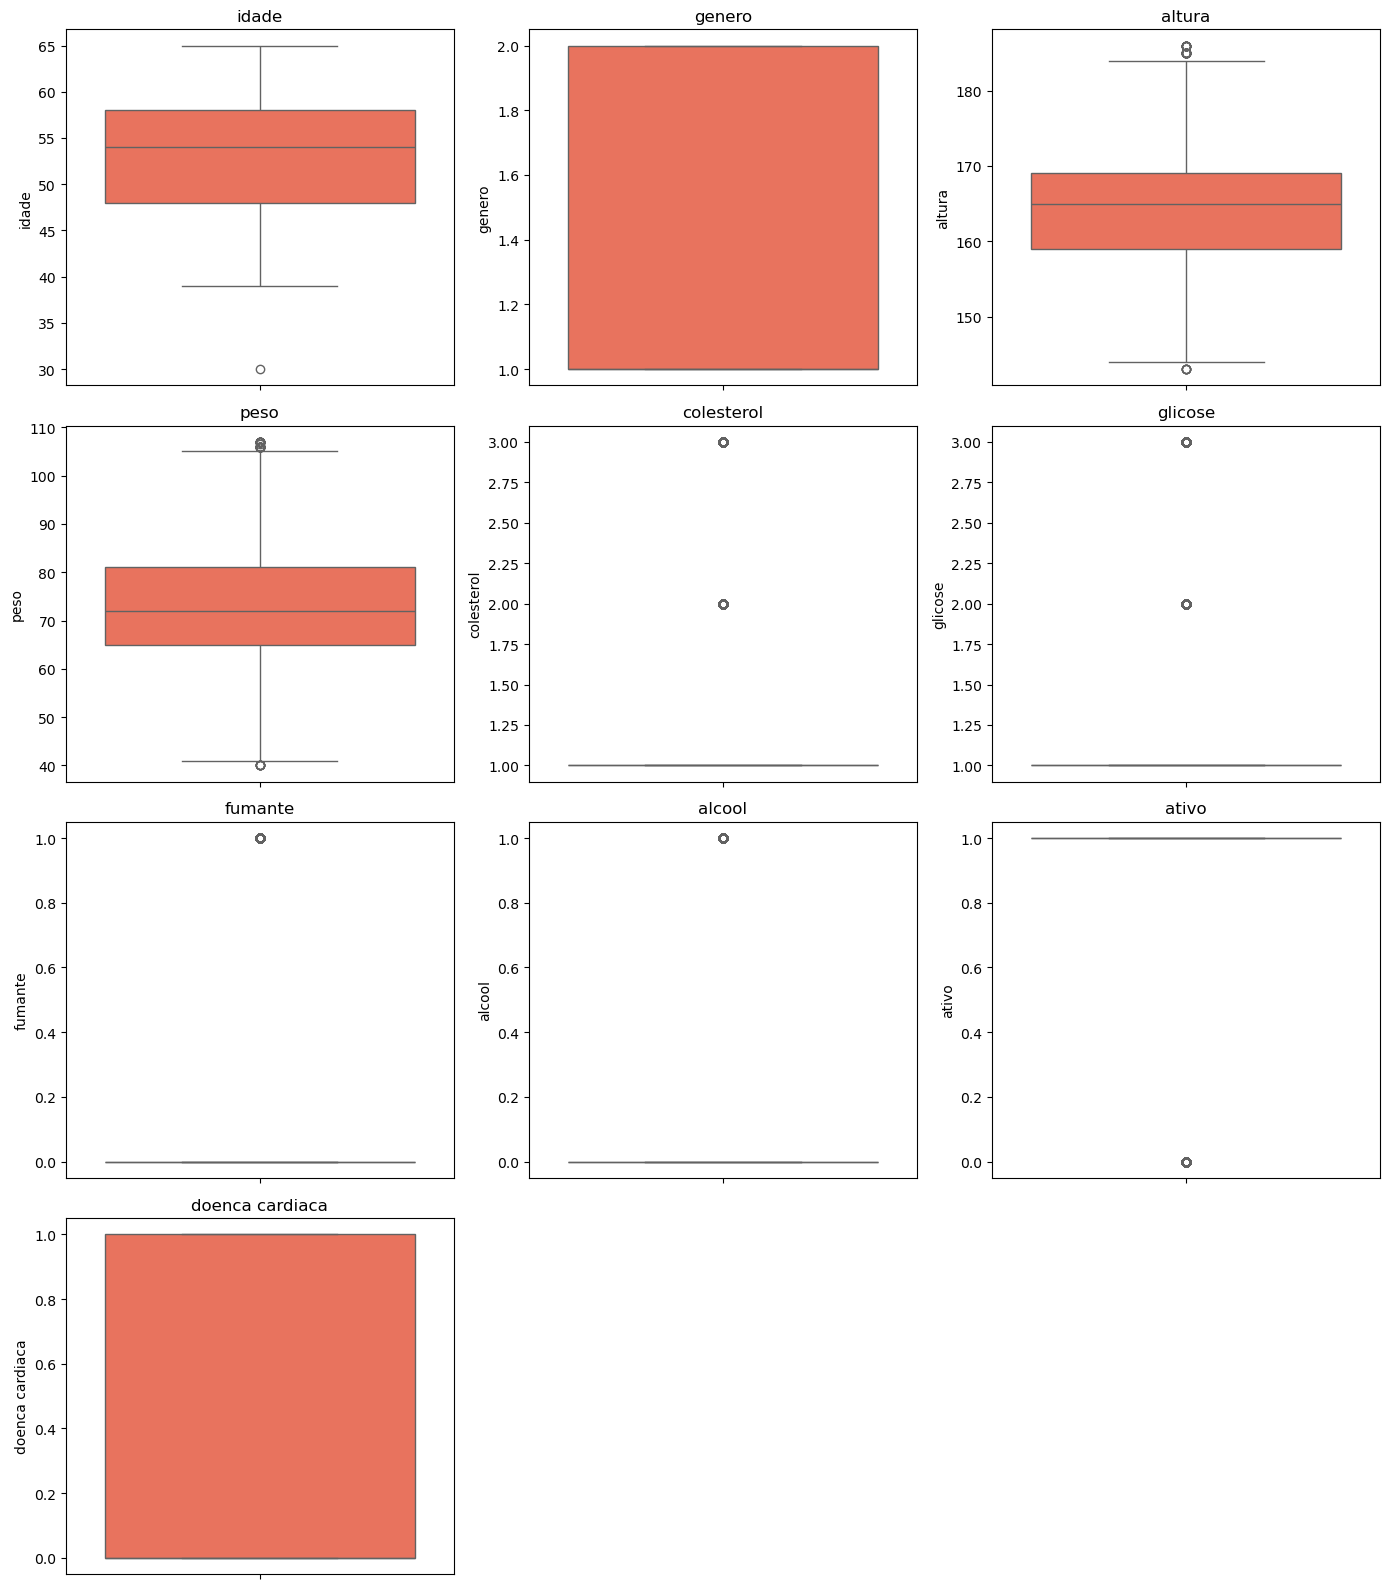

In [7]:
# removendo outliers
# base = base[(base["altura"] >= 140) & (base["altura"] <= 230)]
# base = base[(base["peso"] >= 40)]

# removendo outliers das colunas maior quantidade de outliers
base = outliers_iqr(base, ["altura", "peso"])

# verificando outliers novamente - apenas colunas contínuas
boxplot(base)

## **Analise Exploratoria (EDA)**

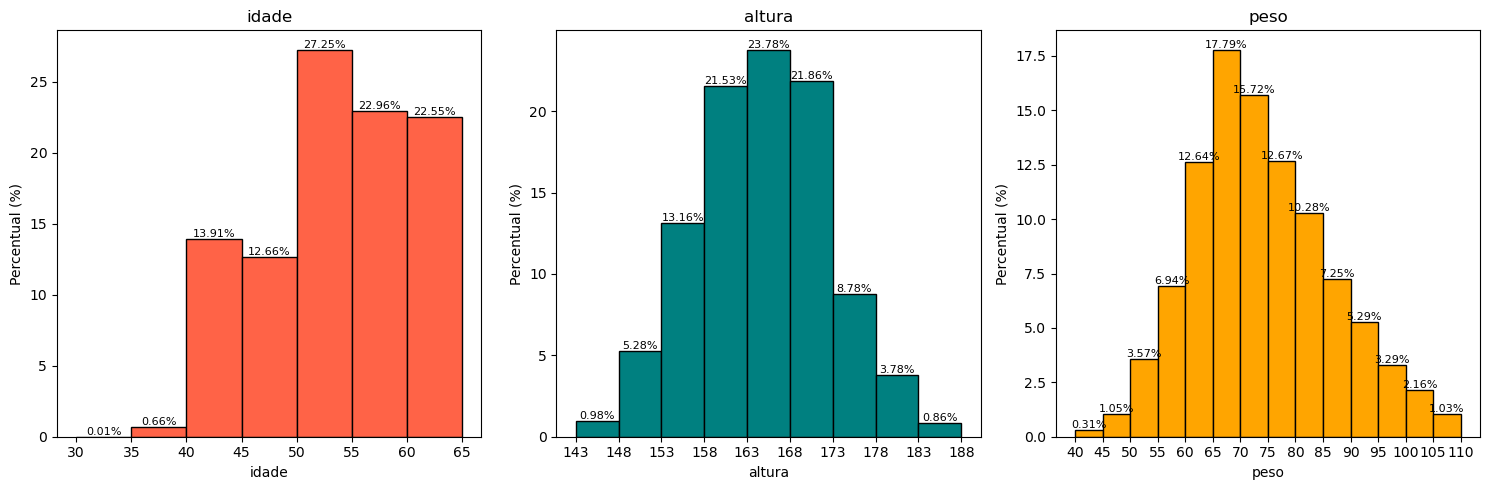

In [8]:
# histograma 
histograma(base, ['idade', 'altura', 'peso'])

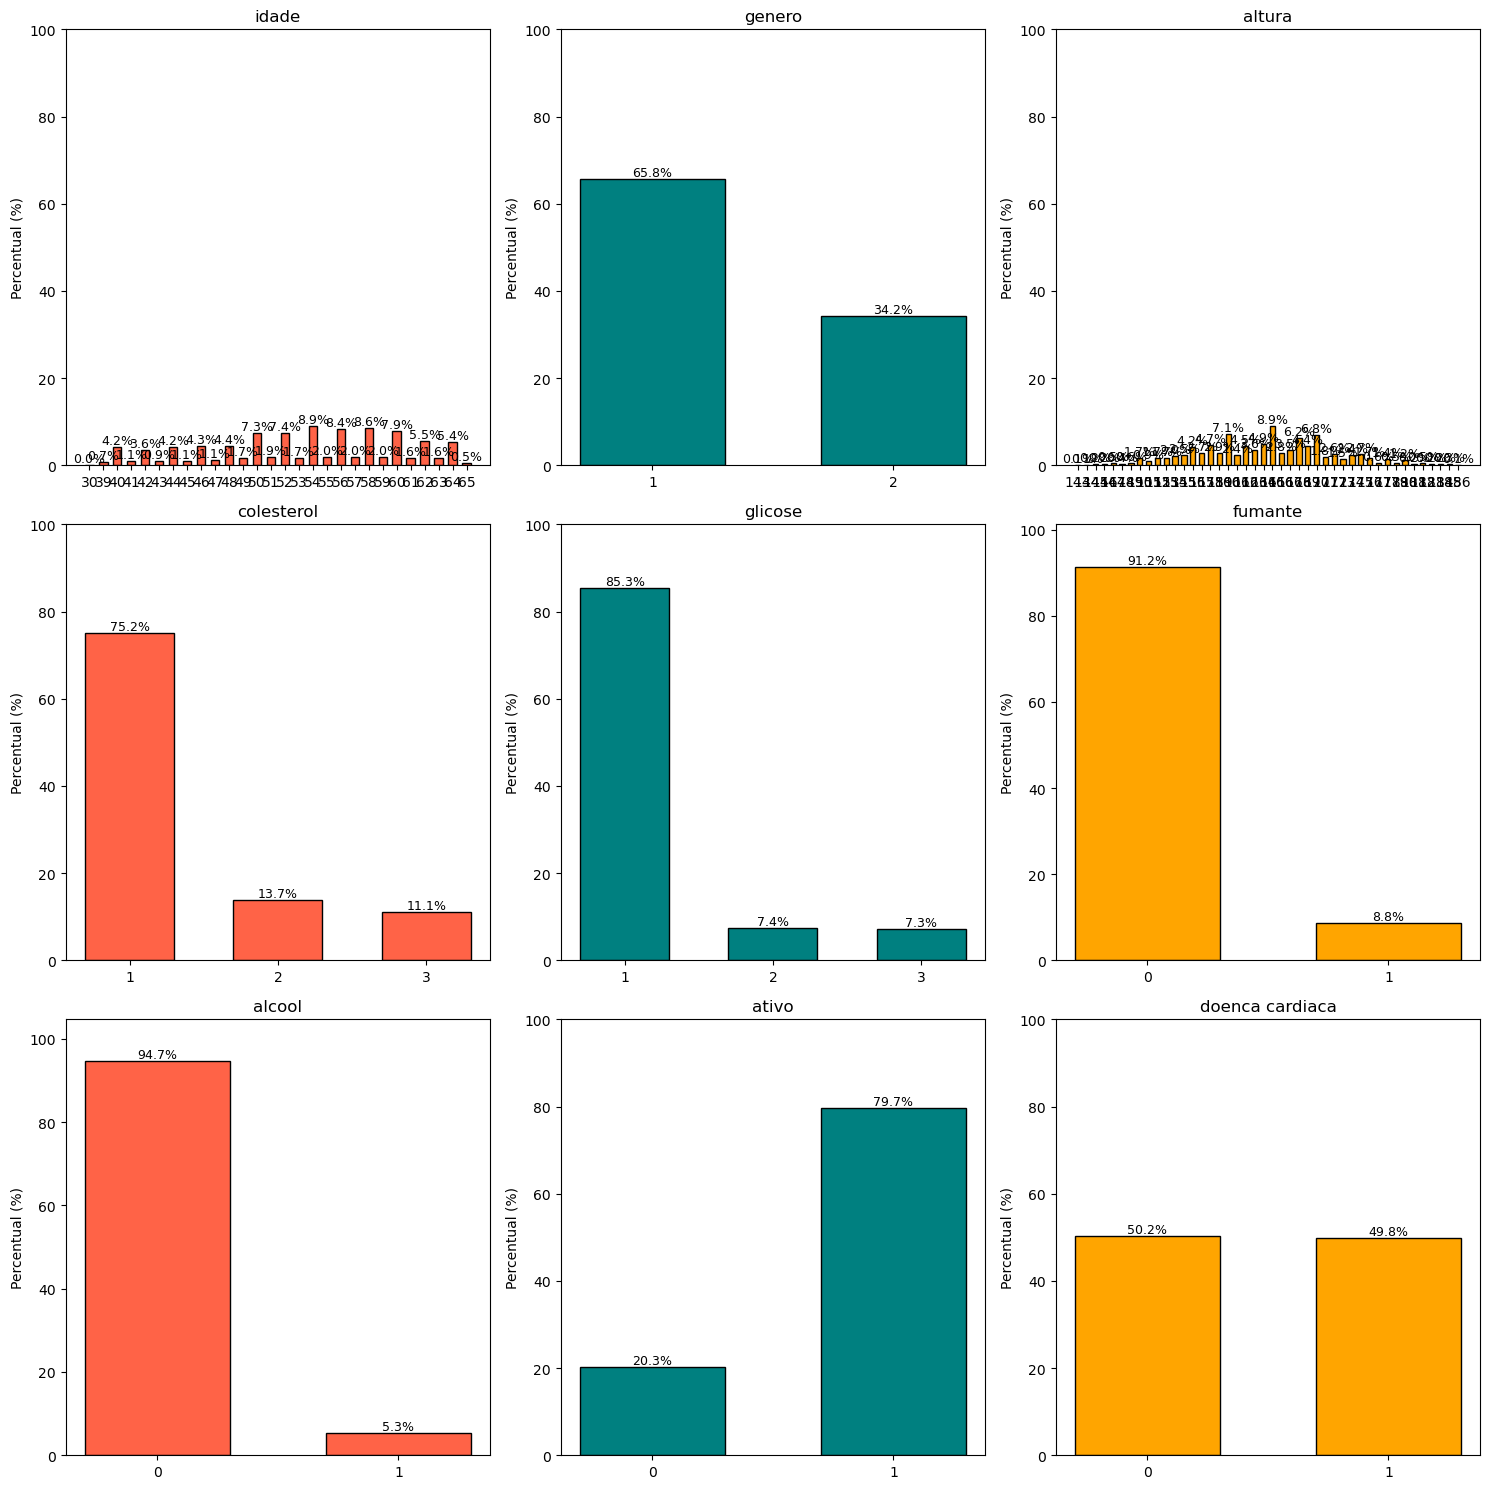

In [9]:
plot_categoricas(base)

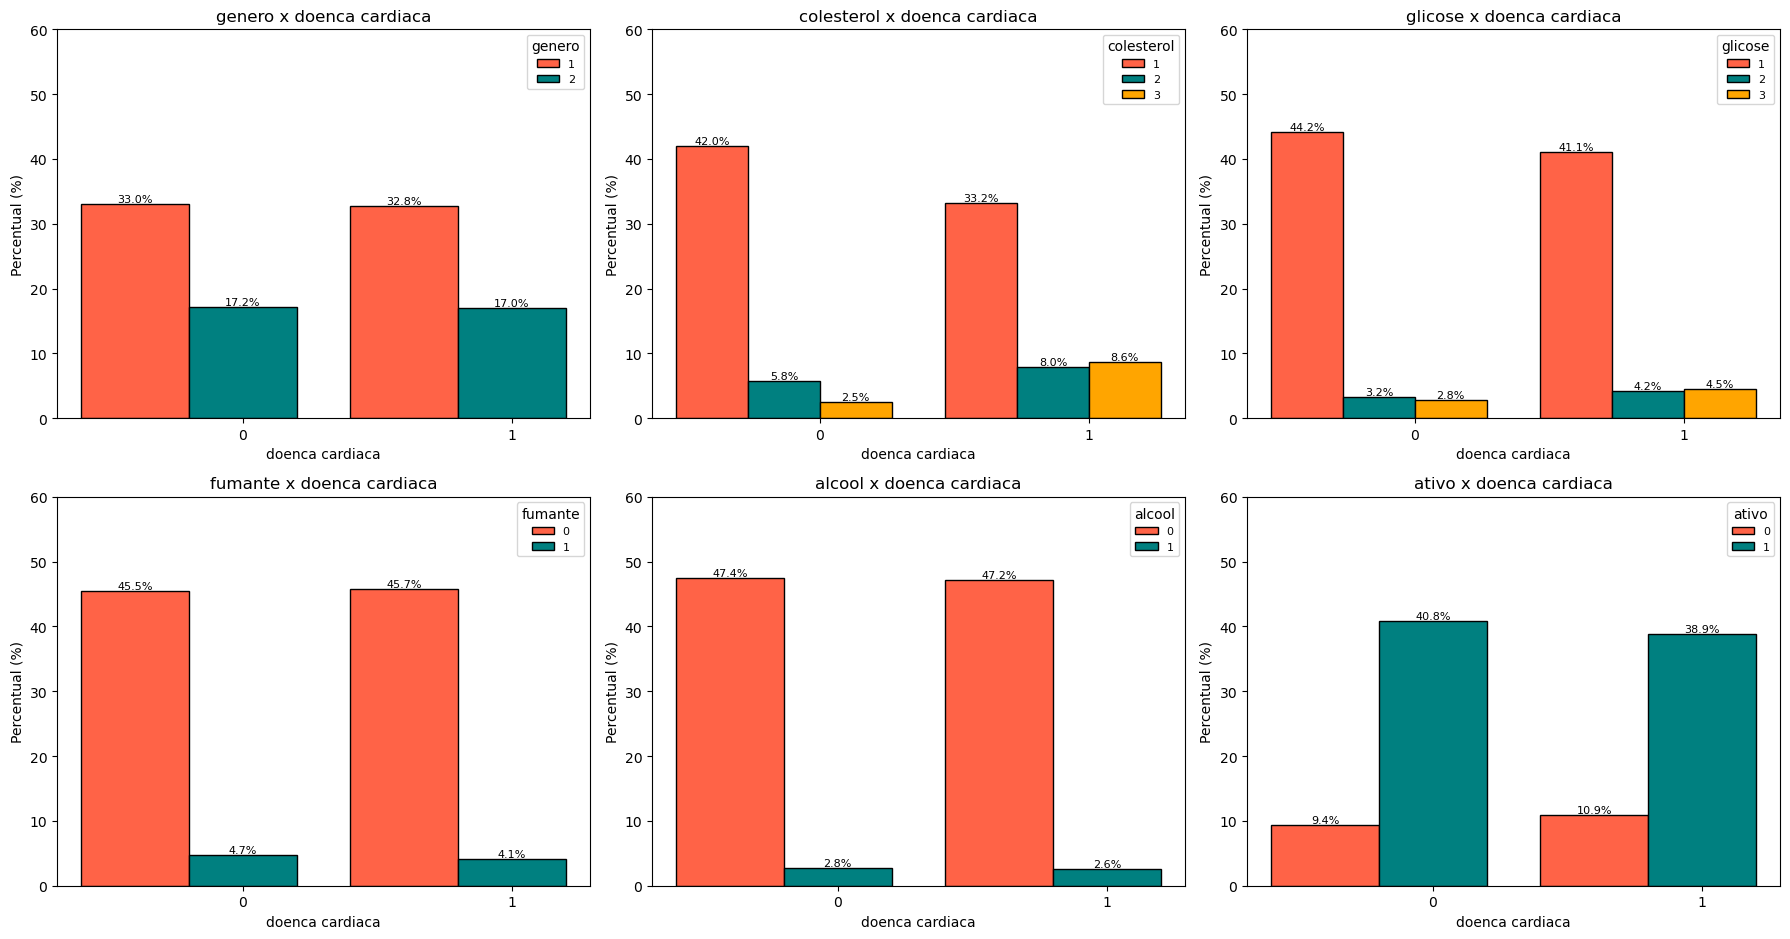

In [10]:
categoricasXtarget(base, 'doenca cardiaca', ['genero', 'colesterol', 'glicose', 'fumante', 'alcool', 'ativo'])

### **Matriz de Correlação e Insights**



In [14]:
 # codificação e reordenamento de colunas
df = pd.get_dummies(base,columns=['glicose'],prefix='glicose') 
df = pd.get_dummies(df,columns=['colesterol'],prefix='colesterol') 
df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)

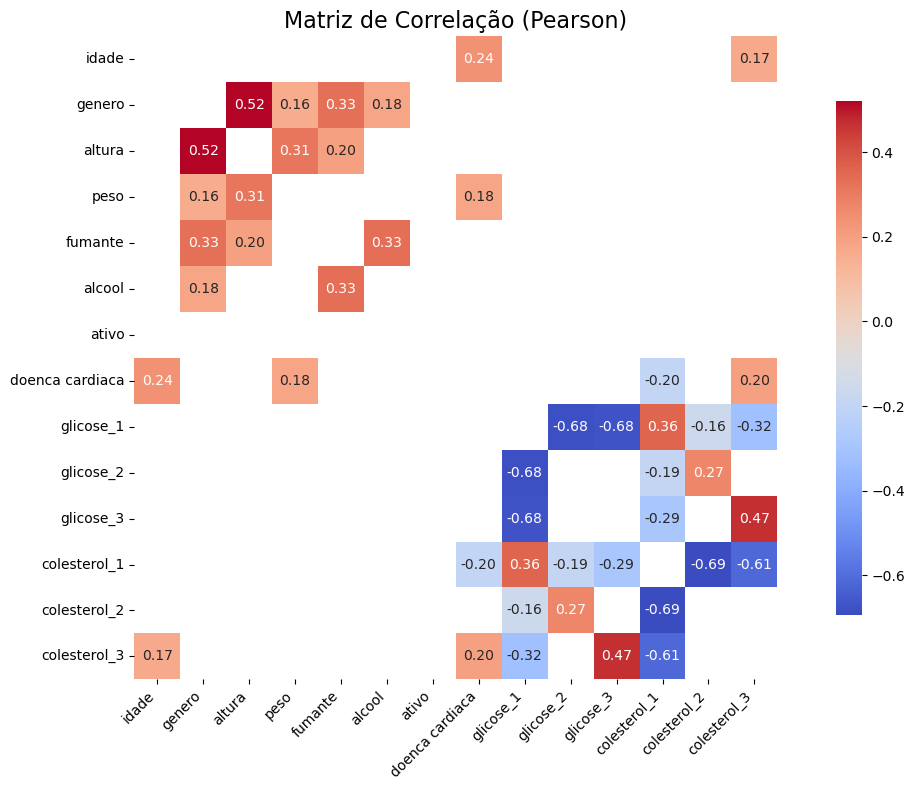

In [16]:
correlacao(df)

## **Separando base de dados**

## **Treinamento do modelo**

## **Teste do modelo**

## **Explicando**

In [12]:
# O que é regressão logistica.
# 
# Porque a regressão logistica é um modelo de classificação.
# 
# EPontos em comum a regressão logistica e a regressão linear.
# 